## Initialization

In [ ]:
from google.colab import drive
import os
import shutil

# mount google drive containing data, mil library
drive.mount("/content/drive")

# copy code folder to local directory
if not os.path.exists(os.path.join(os.getcwd(), "code")):
    shutil.copytree(
        "/content/drive/MyDrive/Academic/NU/Y1Q1/ELEC_ENG_395/weak_supervision/weak_supervision_project/code/",
        os.path.join(os.getcwd(), "code")
    )

Mounted at /content/drive


## Make code importable

The functions provided in the /code directory provide functions for loading data, measuring performance, and building models. This folder is not a package, so we add this folder to the system path so that the modules and functions are importable.

In [ ]:
import sys
sys.path.append(os.path.join(os.getcwd(), "code"))

## Turn off TensorFlow warnings

Improve readability of output.

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

## Create datasets

Create `tf.data.Dataset` objects for the train, validation, and test sets using the description from the provided *dataset.csv* file.

These objects are essentially iterators that will emit tuples of the form `(features, labels)`. TensorFlow adds some useful features like batching, prefetching, and caching that a standard iterator doesn't provide.

In [ ]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

from dataset import dataset
import tensorflow as tf

# dataset parameters
precision = tf.float16 # working with half-float can reduce memory use and accelerate training
cache = True # caching data can increase training speed but can also cause memory errors
shuffle = True # if possible, data should be shuffled so that it isn't shown in the same order each epoch
structured = False # load in a flattened K x D format
D = 1280 # dimensionality of features extracted at each patch
batch = 1 # process one slide at a time, data will have form 1 x K x D
prefetch = 4 # the number of samples to prefetch

# download data and generate tf.data.Dataset objects
train, validation, test, desc = dataset(
    name="tcga_glioma",
    path="/content/drive/MyDrive/Academic/NU/Y1Q1/ELEC_ENG_395/weak_supervision/weak_supervision_project/",
    structured=structured,
    precision=precision,
)

# isolate label and apply one-hot encoding
train = train.map(lambda x, y: (x, tf.one_hot(y["two_year_survival"], 2)))
validation = validation.map(lambda x, y: (x, tf.one_hot(y["two_year_survival"], 2)))
test = test.map(lambda x, y: (x, tf.one_hot(y["two_year_survival"], 2)))

# prefetch and batch
train = train.batch(batch).prefetch(prefetch)
validation = validation.batch(batch).prefetch(prefetch)
test = test.batch(batch).prefetch(prefetch)

# apply caching and shuffling
if shuffle:
    train = train.shuffle(417, reshuffle_each_iteration=True)
    validation = validation.shuffle(53, reshuffle_each_iteration=True)
    test = test.shuffle(53, reshuffle_each_iteration=True)
if cache:
    train = train.cache()
    validation = validation.cache()
    test = test.cache()

# print description
print(desc)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
This dataset contains features extracted from whole-slide images for 523 samples from the combined TCGA GBM and LGG datasets. Each sample is represented by an array of features extracted from tissue-containing tiles at 10X magnification using an ImageNet pre-trained EfficientNetV2S network. Additional data includesubject age, gender, IDH/1p19q molecular classification, and overall survival (osr).


## A simple baseline model
## (ORIGINAL VERSION! NOTHING IS MODIFIED HERE EXCEPT FOR THE MODEL NAME)

This is a simple model that applies a dense layer to each instance, averages this output for all instances, and then transforms this averaged result with a single dense layer.

In [ ]:
### ORIGINAL VERSION!!!! NOTHING IS MODIFIED HERE EXCEPT FOR THE MODEL NAME ###

from metrics import Balanced, F1

# metrics to monitor performance during training
metrics = [
    F1(),
    tf.keras.metrics.AUC(curve='ROC')
]

# build and compile model
input_layer = tf.keras.Input([None, D])
dense1 = tf.keras.layers.Dense(256, name="dense1")(input_layer)
pooled = tf.keras.layers.GlobalAveragePooling1D()(dense1)
dense2 = tf.keras.layers.Dense(2, name="dense2")(pooled)

### FOR STEP 2!!!
dense2 = tf.keras.layers.Dropout(0.1)(dense2)
###

softmax = tf.keras.layers.Lambda( # this trick addresses a problem with the keras softmax function
    lambda x: tf.exp(x) / tf.reduce_sum(tf.exp(x)),
    name="softmax",
    )(dense2)

model1 = tf.keras.Model(inputs=input_layer, outputs=softmax)
model1.compile(optimizer=tf.keras.optimizers.Adam(),
               loss={"softmax": tf.keras.losses.BinaryCrossentropy()}, # learning_rate=0.001 (default) is best
               metrics={"softmax": metrics})
# Original One
model1.fit(train, batch_size=1, epochs=30, validation_data=validation, validation_freq=1)
# Saving results, because Keras often reset history after evaluating or predicting
history1 = model1.history
simple_test1 = model1.evaluate(test)
print(f"Baseline   : test loss: {simple_test1[0]}, F1: {simple_test1[1]}, AUC: {simple_test1[2]}")

Epoch 1/30
417/417 [==============================] - 47s 109ms/step - loss: 1.1277 - f1: 0.4715 - auc_32: 0.6134 - val_loss: 0.5945 - val_f1: 0.3765 - val_auc_32: 0.7659
Epoch 2/30
417/417 [==============================] - 38s 90ms/step - loss: 0.7275 - f1: 0.4781 - auc_32: 0.6849 - val_loss: 0.5679 - val_f1: 0.4176 - val_auc_32: 0.7885
Epoch 3/30
417/417 [==============================] - 34s 82ms/step - loss: 0.6719 - f1: 0.4535 - auc_32: 0.6970 - val_loss: 0.5758 - val_f1: 0.3614 - val_auc_32: 0.7805
Epoch 4/30
417/417 [==============================] - 51s 123ms/step - loss: 0.6424 - f1: 0.4688 - auc_32: 0.7290 - val_loss: 0.5687 - val_f1: 0.3765 - val_auc_32: 0.7917
Epoch 5/30
417/417 [==============================] - 35s 83ms/step - loss: 0.6017 - f1: 0.4741 - auc_32: 0.7637 - val_loss: 0.5693 - val_f1: 0.3614 - val_auc_32: 0.7994
Epoch 6/30
417/417 [==============================] - 34s 81ms/step - loss: 0.6020 - f1: 0.4755 - auc_32: 0.7598 - val_loss: 0.5402 - val_f1: 0.4301

## A simple baseline model
## (Tuned Version)

In [ ]:
## TUNED VERSION ###

# metrics to monitor performance during training
metrics = [
    F1(),
    tf.keras.metrics.AUC(curve='ROC')
]

# build and compile model
input_layer = tf.keras.Input([None, D])
dense1 = tf.keras.layers.Dense(256, name="dense1")(input_layer)
pooled = tf.keras.layers.GlobalAveragePooling1D()(dense1)
dense2 = tf.keras.layers.Dense(2, name="dense2")(pooled)

### FOR STEP 2!!!
dense2 = tf.keras.layers.Dropout(0.1)(dense2)
###

softmax = tf.keras.layers.Lambda( # this trick addresses a problem with the keras softmax function
    lambda x: tf.exp(x) / tf.reduce_sum(tf.exp(x)),
    name="softmax",
    )(dense2)

model2 = tf.keras.Model(inputs=input_layer, outputs=softmax)
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.losses import BinaryCrossentropy as BCe
# Early Stopping Setup
early_stopping =  EarlyStopping(monitor='val_loss',  patience=5, verbose=1, mode='min', restore_best_weights=True)
ReduceLR = ReduceLROnPlateau(monitor='val_loss',factor=0.5, patience=2, min_lr=0.00001)
model2.compile(optimizer=tf.keras.optimizers.Adam(),
              loss={"softmax": tf.keras.losses.BinaryCrossentropy()},
              metrics={"softmax": metrics})
# Modified One
model2.fit(train, batch_size=2, epochs=30, validation_data=validation, validation_freq=1, callbacks=[early_stopping, ReduceLR]) # batch_size = 2 is best
# Saving results, because Keras often reset history after evaluating or predicting or saving
history2 = model2.history
simple_test2 = model2.evaluate(test)
print(f"Tuned   : test loss: {simple_test2[0]}, F1: {simple_test2[1]}, AUC: {simple_test2[2]}")
model2.save('/content/drive/MyDrive/Academic/NU/Y1Q1/ELEC_ENG_395/weak_supervision/weak_supervision_project/tuned1')

Epoch 1/30
417/417 [==============================] - 37s 85ms/step - loss: 1.0586 - f1: 0.4883 - auc_31: 0.6113 - val_loss: 0.5895 - val_f1: 0.3765 - val_auc_31: 0.7714 - lr: 0.0010
Epoch 2/30
417/417 [==============================] - 38s 92ms/step - loss: 0.7178 - f1: 0.4661 - auc_31: 0.7088 - val_loss: 0.6466 - val_f1: 0.2090 - val_auc_31: 0.7375 - lr: 0.0010
Epoch 3/30
417/417 [==============================] - 34s 82ms/step - loss: 0.6478 - f1: 0.4674 - auc_31: 0.7154 - val_loss: 0.5538 - val_f1: 0.4176 - val_auc_31: 0.8060 - lr: 0.0010
Epoch 4/30
417/417 [==============================] - 36s 86ms/step - loss: 0.6218 - f1: 0.4794 - auc_31: 0.7423 - val_loss: 0.5655 - val_f1: 0.4045 - val_auc_31: 0.7892 - lr: 0.0010
Epoch 5/30
417/417 [==============================] - 34s 82ms/step - loss: 0.6097 - f1: 0.4633 - auc_31: 0.7614 - val_loss: 0.5597 - val_f1: 0.3614 - val_auc_31: 0.8014 - lr: 0.0010
Epoch 6/30
417/417 [==============================] - 36s 86ms/step - loss: 0.5513 - 

## A simple model history writing-up


In [ ]:
# Write results up just in case...
history1.history
history2.history

{'loss': [1.0585746765136719,
  0.7178100347518921,
  0.6478111147880554,
  0.6218472719192505,
  0.6097443103790283,
  0.5513071417808533,
  0.5646025538444519,
  0.5544971823692322,
  0.5485787391662598,
  0.5303753614425659,
  0.5181812047958374,
  0.5176662802696228,
  0.5070274472236633,
  0.520935595035553,
  0.49795761704444885,
  0.5019140839576721,
  0.49074825644493103,
  0.4810461699962616,
  0.47158101201057434],
 'f1': [0.48834356665611267,
  0.46606913208961487,
  0.4674329459667206,
  0.47940075397491455,
  0.46332046389579773,
  0.46469834446907043,
  0.4806973934173584,
  0.4767879545688629,
  0.47547170519828796,
  0.46469834446907043,
  0.4701397716999054,
  0.4591439664363861,
  0.4767879545688629,
  0.47414880990982056,
  0.4701397716999054,
  0.4728192090988159,
  0.4563233256340027,
  0.46193549036979675,
  0.4591439664363861],
 'auc_31': [0.6113411784172058,
  0.708794116973877,
  0.7154133319854736,
  0.7422637939453125,
  0.761436939239502,
  0.794000744819641

## A simple model graphs


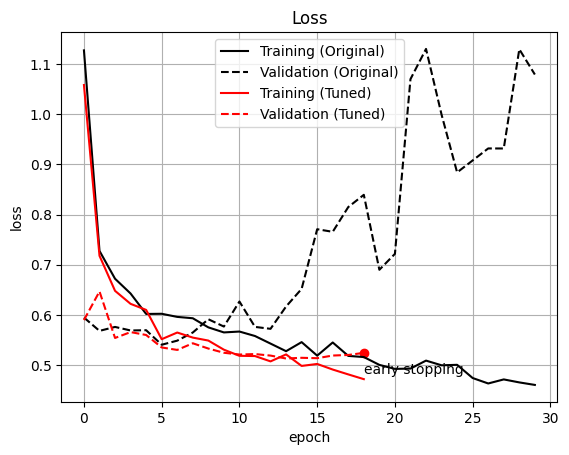

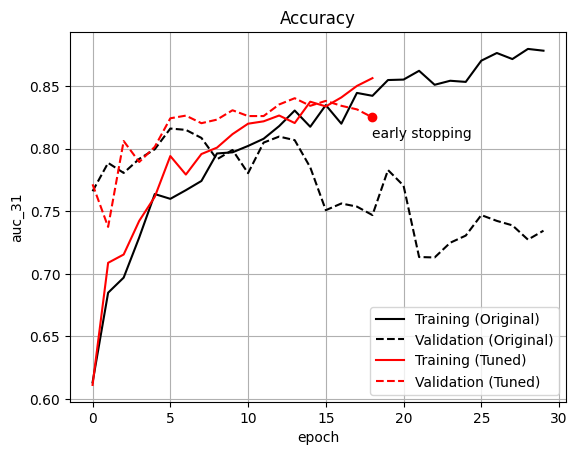

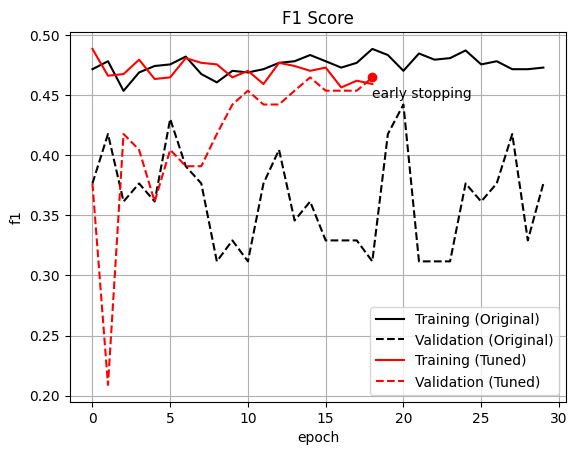

In [ ]:
### Graph Depictor
import matplotlib.pyplot as plt

def visualize_loss(session1, session2, Name, key1, key2):
    plt.figure()
    ax1 = range(len(session1.history[key1]))

    plt.plot(ax1, session1.history[key1], color='Black', label="Training (Original)")
    plt.plot(ax1, session1.history[key2], linestyle = "--", color='Black', label="Validation (Original)")
    if Name == "Accuracy":
      key1 = "auc_31"
      key2 = "val_auc_31"
    ax2 = range(len(session2.history[key1]))
    plt.plot(ax2, session2.history[key1], color='Red', label="Training (Tuned)")
    plt.plot(ax2, session2.history[key2], linestyle = "--", color='Red', label="Validation (Tuned)")
    if len(ax1) > len(ax2): # if model2 has been early-stopped
      plt.scatter(len(session2.history[key2])-1, session2.history[key2][-1], color='red')
      plt.annotate('early stopping', (len(session2.history[key2])-1, session2.history[key2][-1]), textcoords="offset points", xytext=(0,-15), ha='left')
    plt.xlabel("epoch")
    plt.ylabel(key1)
    plt.grid()
    plt.legend()
    plt.title(Name)
visualize_loss(history1, history2, "Loss", "loss", "val_loss")
visualize_loss(history1, history2, "Accuracy", "auc_32", "val_auc_32")
visualize_loss(history1, history2, "F1 Score", "f1", "val_f1")

## A model with attention-based pooling
## ORIGINAL VERSION!
This model is similar to the model covered in class. Each instance receives an attention score, and these scores are used to perform a weighted-average pooling of the instances. This allows the model to direct its focus to specific sets of tiles.

In [ ]:
# first layer
input_layer = tf.keras.Input([None, D])
zk = tf.squeeze(input_layer, axis=0)
hk = tf.keras.layers.Dense(512, activation="relu", name="hk")(zk)

# attention shared layers ("backbone")
v = tf.keras.layers.Dense(256, activation="tanh")(hk)
v = tf.keras.layers.Dropout(0.1, name="v")(v)
u = tf.keras.layers.Dense(256, activation="sigmoid")(hk)
u = tf.keras.layers.Dropout(0.1, name="u")(u)
uv = tf.multiply(u, v)

# attention branch layers
w1 = tf.keras.layers.Dense(1, activation="relu")(uv)
w1 = tf.keras.layers.Dropout(0.1, name="w1")(w1)
w2 = tf.keras.layers.Dense(1, activation="relu")(uv)
w2 = tf.keras.layers.Dropout(0.1, name="w2")(w2)

# apply transformations to attention weights
e1 = tf.exp(w1)
e2 = tf.exp(w2)

# normalize attention weights
total = tf.reduce_sum(e1) + tf.reduce_sum(e2)
n1 = tf.math.divide_no_nan(e1, total, name="n1")
n2 = tf.math.divide_no_nan(e2, total, name="n2")

# weighted average pooling
p1 = tf.tensordot(tf.reshape(n1, [1, -1]), hk, axes=1) / tf.reduce_sum(tf.reshape(n1, [-1]))
p2 = tf.tensordot(tf.reshape(n2, [1, -1]), hk, axes=1) / tf.reduce_sum(tf.reshape(n2, [-1]))

# final layer for predictions
c1 = tf.keras.layers.Dense(1, activation="linear")(p1)
c1 = tf.keras.layers.Dropout(0.1, name="c1")(c1)
c2 = tf.keras.layers.Dense(1, activation="linear")(p2)
c2 = tf.keras.layers.Dropout(0.1, name="c2")(c2)

### DROPOUT IS ALREADY IMPLEMENTED

# combine outputs
scores = tf.keras.layers.Concatenate(axis=1)([c1, c2])
softmax = tf.keras.layers.Lambda( # this trick addresses a problem with the keras softmax function
    lambda x: tf.exp(x) / tf.reduce_sum(tf.exp(x)),
    name="softmax",
    )(scores)

# create model
model3 = tf.keras.Model(inputs=input_layer,outputs=[softmax, w1, w2])
model3.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss={'softmax': tf.keras.losses.BinaryCrossentropy(), "w1": None, "w2": None},
    metrics={'softmax': metrics, "w1": None, "w2": None}
)
# train model
model3.fit(train, batch_size=batch, epochs=15,
          validation_data=validation, validation_freq=1)
history3 = model3.history

Epoch 1/15
417/417 [==============================] - 137s 274ms/step - loss: 0.6447 - softmax_loss: 0.6447 - softmax_softmax_softmax_softmax_softmax_softmax_f1: 0.4694 - softmax_softmax_softmax_softmax_softmax_softmax_auc_1: 0.7114 - val_loss: 0.5603 - val_softmax_loss: 0.5603 - val_softmax_softmax_softmax_softmax_softmax_softmax_f1: 0.4301 - val_softmax_softmax_softmax_softmax_softmax_softmax_auc_1: 0.7992
Epoch 2/15
417/417 [==============================] - 110s 264ms/step - loss: 0.5906 - softmax_loss: 0.5906 - softmax_softmax_softmax_softmax_softmax_softmax_f1: 0.4506 - softmax_softmax_softmax_softmax_softmax_softmax_auc_1: 0.7609 - val_loss: 0.5382 - val_softmax_loss: 0.5382 - val_softmax_softmax_softmax_softmax_softmax_softmax_f1: 0.4301 - val_softmax_softmax_softmax_softmax_softmax_softmax_auc_1: 0.8174
Epoch 3/15
417/417 [==============================] - 120s 288ms/step - loss: 0.5736 - softmax_loss: 0.5736 - softmax_softmax_softmax_softmax_softmax_softmax_f1: 0.4563 - softm

In [ ]:
# evaluate model
simple_test3 = model3.evaluate(test)
print(f"Tuned AP   : test loss: {simple_test3[1]}, F1: {simple_test3[2]}, AUC: {simple_test3[3]}")
" Below result is a typo. Tuned -> Original."

53/53 [==============================] - 6s 114ms/step - loss: 0.6136 - softmax_loss: 0.6136 - softmax_softmax_softmax_softmax_softmax_softmax_f1: 0.4421 - softmax_softmax_softmax_softmax_softmax_softmax_auc_1: 0.8099
Tuned AP   : test loss: 0.6136447191238403, F1: 0.4421052634716034, AUC: 0.8098967671394348


In [ ]:
history3.history

{'loss': [0.6446636319160461,
  0.5906352400779724,
  0.5735830068588257,
  0.5506676435470581,
  0.5423921942710876,
  0.504129946231842,
  0.47386711835861206,
  0.4765416383743286,
  0.43337804079055786,
  0.42457160353660583,
  0.3810560703277588,
  0.3496614396572113,
  0.2966737449169159,
  0.2578372657299042,
  0.2664250135421753],
 'softmax_loss': [0.6446636319160461,
  0.5906352400779724,
  0.5735830068588257,
  0.5506676435470581,
  0.5423921942710876,
  0.504129946231842,
  0.47386711835861206,
  0.4765416383743286,
  0.43337804079055786,
  0.42457160353660583,
  0.3810560703277588,
  0.3496614396572113,
  0.2966737449169159,
  0.2578372657299042,
  0.2664250135421753],
 'softmax_softmax_softmax_softmax_softmax_softmax_f1': [0.4694104492664337,
  0.45059287548065186,
  0.4563233256340027,
  0.46054333448410034,
  0.4520367980003357,
  0.4674329459667206,
  0.46469834446907043,
  0.46054333448410034,
  0.46332046389579773,
  0.4563233256340027,
  0.4674329459667206,
  0.47547

## A model with attention-based pooling
## (TUNED VERSION)

In [ ]:
#### TUNED MODEL!!!!

# first layer
input_layer = tf.keras.Input([None, D])
zk = tf.squeeze(input_layer, axis=0)
hk = tf.keras.layers.Dense(512, activation="relu", name="hk")(zk)

# attention shared layers ("backbone")
v = tf.keras.layers.Dense(256, activation="tanh")(hk)
v = tf.keras.layers.Dropout(0.1, name="v")(v)
u = tf.keras.layers.Dense(256, activation="sigmoid")(hk)
u = tf.keras.layers.Dropout(0.1, name="u")(u)
uv = tf.multiply(u, v)

# attention branch layers
w1 = tf.keras.layers.Dense(1, activation="relu")(uv)
w1 = tf.keras.layers.Dropout(0.1, name="w1")(w1)
w2 = tf.keras.layers.Dense(1, activation="relu")(uv)
w2 = tf.keras.layers.Dropout(0.1, name="w2")(w2)

# apply transformations to attention weights
e1 = tf.exp(w1)
e2 = tf.exp(w2)

# normalize attention weights
total = tf.reduce_sum(e1) + tf.reduce_sum(e2)
n1 = tf.math.divide_no_nan(e1, total, name="n1")
n2 = tf.math.divide_no_nan(e2, total, name="n2")

# weighted average pooling
p1 = tf.tensordot(tf.reshape(n1, [1, -1]), hk, axes=1) / tf.reduce_sum(tf.reshape(n1, [-1]))
p2 = tf.tensordot(tf.reshape(n2, [1, -1]), hk, axes=1) / tf.reduce_sum(tf.reshape(n2, [-1]))

# final layer for predictions
c1 = tf.keras.layers.Dense(1, activation="linear")(p1)
c1 = tf.keras.layers.Dropout(0.1, name="c1")(c1) # FOR STEP ""
c2 = tf.keras.layers.Dense(1, activation="linear")(p2)
c2 = tf.keras.layers.Dropout(0.1, name="c2")(c2) # FOR STEP 2

### DROPOUT IS ALREADY IMPLEMENTED

# combine outputs
scores = tf.keras.layers.Concatenate(axis=1)([c1, c2])
softmax = tf.keras.layers.Lambda( # this trick addresses a problem with the keras softmax function
    lambda x: tf.exp(x) / tf.reduce_sum(tf.exp(x)),
    name="softmax",
    )(scores)

model4 = tf.keras.Model(inputs=input_layer,outputs=[softmax, w1, w2])
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.losses import BinaryCrossentropy as BCe
# Early Stopping Setup
early_stopping =  EarlyStopping(monitor='val_loss',  patience=4, verbose=1, mode='min', restore_best_weights=True)
ReduceLR = ReduceLROnPlateau(monitor='val_loss',factor=0.5, patience=2, min_lr=0.00001)
model4.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss={'softmax': tf.keras.losses.BinaryCrossentropy(), "w1": None, "w2": None},
    metrics={'softmax': metrics, "w1": None, "w2": None}
)
# train model
model4.fit(train, batch_size=batch, epochs=15,
          validation_data=validation, validation_freq=1, callbacks=[early_stopping, ReduceLR])
history4 = model4.history
model4.save('/content/drive/MyDrive/Academic/NU/Y1Q1/ELEC_ENG_395/weak_supervision/weak_supervision_project/tunedAP')

Epoch 1/15
417/417 [==============================] - 116s 271ms/step - loss: 0.6543 - softmax_loss: 0.6543 - softmax_softmax_softmax_softmax_softmax_softmax_softmax_f1: 0.4659 - softmax_softmax_softmax_softmax_softmax_softmax_softmax_auc_1: 0.7014 - val_loss: 0.5625 - val_softmax_loss: 0.5625 - val_softmax_softmax_softmax_softmax_softmax_softmax_softmax_f1: 0.4421 - val_softmax_softmax_softmax_softmax_softmax_softmax_softmax_auc_1: 0.7987 - lr: 1.0000e-04
Epoch 2/15
417/417 [==============================] - 115s 275ms/step - loss: 0.5833 - softmax_loss: 0.5833 - softmax_softmax_softmax_softmax_softmax_softmax_softmax_f1: 0.4633 - softmax_softmax_softmax_softmax_softmax_softmax_softmax_auc_1: 0.7648 - val_loss: 0.5401 - val_softmax_loss: 0.5401 - val_softmax_softmax_softmax_softmax_softmax_softmax_softmax_f1: 0.4176 - val_softmax_softmax_softmax_softmax_softmax_softmax_softmax_auc_1: 0.8117 - lr: 1.0000e-04
Epoch 3/15
417/417 [==============================] - 125s 300ms/step - loss: 

In [ ]:
history4.history

{'loss': [0.654263436794281,
  0.5832777619361877,
  0.5698261857032776,
  0.5369153618812561,
  0.5288540124893188,
  0.5185341835021973,
  0.45575758814811707,
  0.4480966627597809],
 'softmax_loss': [0.654263436794281,
  0.5832777619361877,
  0.5698261857032776,
  0.5369153618812561,
  0.5288540124893188,
  0.5185341835021973,
  0.45575758814811707,
  0.4480966627597809],
 'softmax_softmax_softmax_softmax_softmax_softmax_softmax_f1': [0.46590909361839294,
  0.46332046389579773,
  0.4520367980003357,
  0.4728192090988159,
  0.46193549036979675,
  0.45347312092781067,
  0.4577373266220093,
  0.46332046389579773],
 'softmax_softmax_softmax_softmax_softmax_softmax_softmax_auc_1': [0.7013535499572754,
  0.764775276184082,
  0.7841496467590332,
  0.8118426203727722,
  0.8213659524917603,
  0.8295119404792786,
  0.8705611228942871,
  0.8762515187263489],
 'val_loss': [0.5624877214431763,
  0.5400868058204651,
  0.5336732864379883,
  0.512072741985321,
  0.5576120615005493,
  0.524024724960

In [ ]:
# evaluate model
simple_test4 = model4.evaluate(test)
print(f"Tuned AP   : test loss: {simple_test4[1]}, F1: {simple_test4[2]}, AUC: {simple_test4[3]}")

53/53 [==============================] - 7s 138ms/step - loss: 0.5153 - softmax_loss: 0.5153 - softmax_softmax_softmax_softmax_softmax_softmax_softmax_f1: 0.4176 - softmax_softmax_softmax_softmax_softmax_softmax_softmax_auc_1: 0.8437
Tuned AP   : test loss: 0.5152637362480164, F1: 0.4175824224948883, AUC: 0.8437166213989258


## A simple model graphs

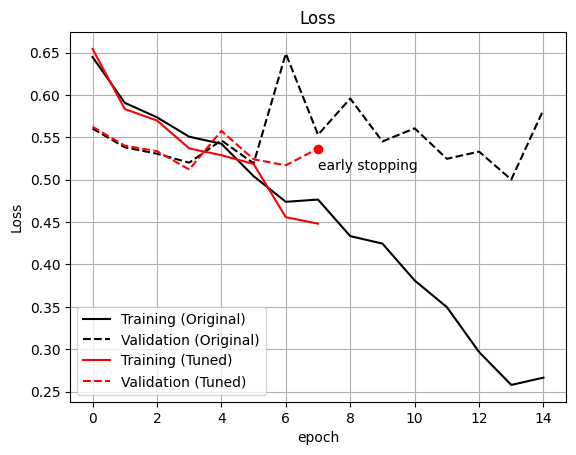

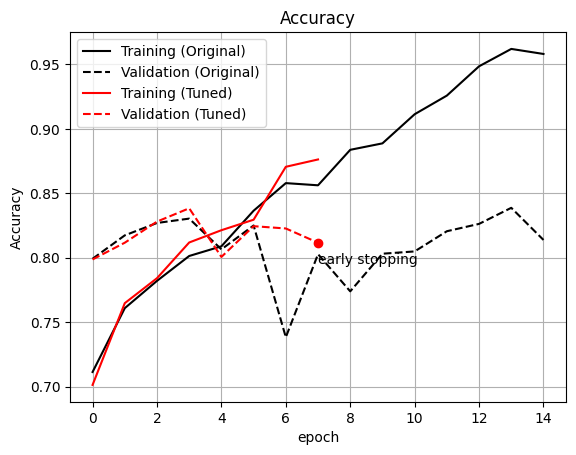

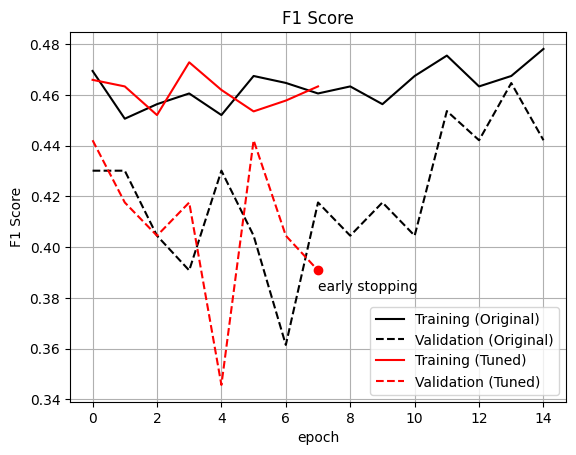

In [ ]:
### Graph Depictor
import matplotlib.pyplot as plt

def visualize_loss(session1, session2, Name, key1, key2):
    plt.figure()
    ax1 = range(len(session1.history[key1]))

    plt.plot(ax1, session1.history[key1], color='Black', label="Training (Original)")
    plt.plot(ax1, session1.history[key2], linestyle = "--", color='Black', label="Validation (Original)")
    if Name == "Accuracy":
      key1 = "softmax_softmax_softmax_softmax_softmax_softmax_softmax_auc_1"
      key2 = "val_softmax_softmax_softmax_softmax_softmax_softmax_softmax_auc_1"
    if Name == "F1 Score":
      key1 = "softmax_softmax_softmax_softmax_softmax_softmax_softmax_f1"
      key2 = "val_softmax_softmax_softmax_softmax_softmax_softmax_softmax_f1"
    ax2 = range(len(session2.history[key1]))
    plt.plot(ax2, session2.history[key1], color='Red', label="Training (Tuned)")
    plt.plot(ax2, session2.history[key2], linestyle = "--", color='Red', label="Validation (Tuned)")
    if len(ax1) > len(ax2): # if model2 has been early-stopped
      plt.scatter(len(session2.history[key2])-1, session2.history[key2][-1], color='red')
      plt.annotate('early stopping', (len(session2.history[key2])-1, session2.history[key2][-1]), textcoords="offset points", xytext=(0,-15), ha='left')
    plt.xlabel("epoch")
    plt.ylabel(Name)
    plt.grid()
    plt.legend()
    plt.title(Name)
visualize_loss(history3, history4, "Loss", "softmax_loss", "val_softmax_loss")
visualize_loss(history3, history4, "Accuracy", "softmax_softmax_softmax_softmax_softmax_softmax_auc_1", "val_softmax_softmax_softmax_softmax_softmax_softmax_auc_1")
visualize_loss(history3, history4, "F1 Score", "softmax_softmax_softmax_softmax_softmax_softmax_f1", "val_softmax_softmax_softmax_softmax_softmax_softmax_f1")

## MODEL LOAD AS "modelL2"

In [ ]:
# LOAD AND COMPILE AND EVALUATION
from metrics import Balanced, F1
metrics = [F1(),tf.keras.metrics.AUC(curve='ROC')]
model2L = tf.keras.models.load_model('/content/drive/MyDrive/Academic/NU/Y1Q1/ELEC_ENG_395/weak_supervision/weak_supervision_project/tuned1/',custom_objects={'f1':F1}, compile=False)
model2L.compile(optimizer=tf.keras.optimizers.Adam(),
               loss={"softmax": tf.keras.losses.BinaryCrossentropy()},
               metrics={"softmax": metrics})
simple_test2L = model2L.evaluate(test)
print(f"Tuned   : test loss: {simple_test2L[0]}, F1: {simple_test2L[1]}, AUC: {simple_test2L[2]}")
model2L.summary()

53/53 [==============================] - 5s 70ms/step - loss: 0.4824 - f1: 0.4421 - auc_4: 0.8676
Tuned   : test loss: 0.48239412903785706, F1: 0.4421052634716034, AUC: 0.8675685524940491
Model: "model_59"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_32 (InputLayer)       [(None, None, 1280)]      0         
                                                                 
 dense1 (Dense)              (None, None, 256)         327936    
                                                                 
 global_average_pooling1d_3  (None, 256)               0         
 1 (GlobalAveragePooling1D)                                      
                                                                 
 dense2 (Dense)              (None, 2)                 514       
                                                                 
 dropout_10 (Dropout)        (None, 2)                 0         
  

## Step 2. Uncertainly

In [ ]:
# Dropout-activated prediction (x100) and Dropout-inhibited prediction (x1)
import numpy as np
import tensorflow as tf
def MCD_Uncertanly(model, test, iteration):
  Uncertanly = []
  for ii in range(iteration):
    print(str(ii+1) + " ", end="")
    # Calculate the uncertainty
    UCTemp = []
    UCTemp = [model(x, training=True)[0] for (x,y) in test] # Dropout Activated
    # print(UCTemp)
    Uncertanly.append(UCTemp)
  print("")
  # Conversion
  Uncertanly = tf.stack(Uncertanly)
  return Uncertanly

# # 100 x 53 x 1 x 2
UCT = MCD_Uncertanly(model2L, test, 100)
print(UCT.shape)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
(100, 53, 2)


In [ ]:
# Find Uncertanly (from 100-avged predictions to STD)
UCT_STD = tf.math.reduce_std(UCT, axis=0) # FIND THE Std!!! -> FOR
UCT_STD = np.array(UCT_STD) # 53 x 2
# Basically STD for each class is the same: take only the first column
UCT_STD = UCT_STD[...,0] # 53 x 1
UCT_STD = np.squeeze(UCT_STD)
# print(UCT_STD)
# 準備完了！ -> UCT_STD (53x1)

# NORMAL PREDICTION!! And Correct/Incorrect Labeling!!!
PDC = [model2L(x, training=False)[0] for (x,y) in test] # Dropout Deactivated
PDC = np.array(PDC)
PDC = np.squeeze(PDC) # 53 x 2
#print(PDC.shape)
# UCT_Mean (予測正解のラベルの【位置】を特定する！！！！！)
UCT_Mean_Arg_Correct = np.argmax(PDC, axis=-1) # 0, 1, 1, 0, 0, ...
#print(UCT_Mean_Arg_Correct)

# Extract True Label
TrueTestLabel = np.argmax(np.array([y for (x,y) in test]), axis=-1) # 本物の答え。
TrueTestLabel = np.squeeze(TrueTestLabel)
#print(TrueTestLabel) # 1, 0, 1, 1, 1, ...

CorrectGroupIndex = UCT_Mean_Arg_Correct == TrueTestLabel
IncorrectGroupIndex = UCT_Mean_Arg_Correct != TrueTestLabel

# Finally
# Make Group: Correct and Wrong Group
CorrectGroup = UCT_STD[CorrectGroupIndex]
IncorrectGroup = UCT_STD[IncorrectGroupIndex]

#print(CorrectGroup)
#print(IncorrectGroup)

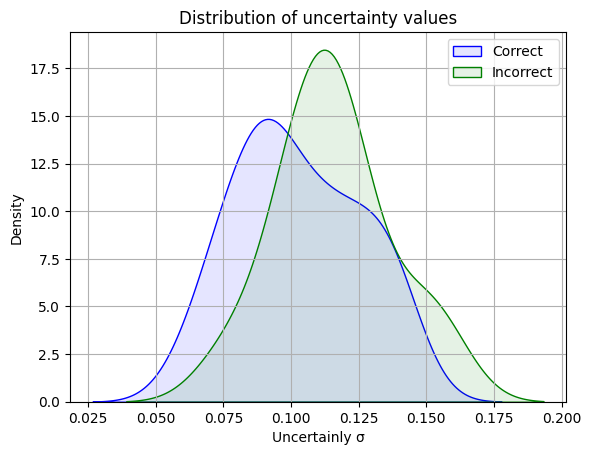

In [ ]:
#### ITS TIME TO MAKE A HISTOGRAM ####
# Histogram (correct (matches with the original prediction) and incorrect predictions)
# 青 (正解) か緑 (不正解)グループは、平均に基づく！！！！！！
# 横軸は、その不確かさに基づく！！！！！！
import numpy as np
import seaborn as sns

plt.figure()
sns.kdeplot(CorrectGroup, color='blue', label='Correct', fill=True, alpha=0.1)
sns.kdeplot(IncorrectGroup, color='green', label='Incorrect', fill=True, alpha=0.1)
plt.xlabel('Uncertainly σ')
plt.ylabel('Density')
plt.grid()
plt.title("Distribution of uncertainty values")
plt.legend()
plt.show()

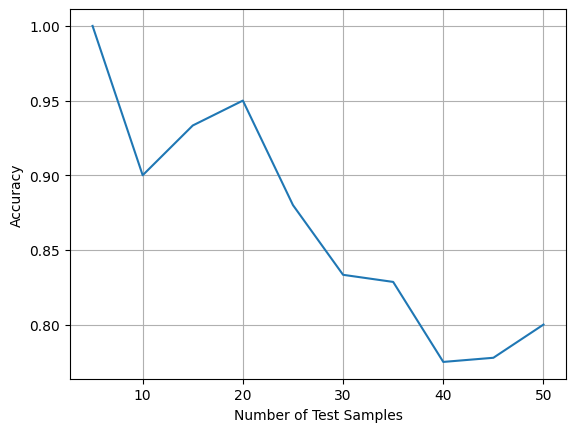

In [ ]:
# 不確実さσiの増加によってテスト・サンプルを並べ替えます。最も確実な5個のサンプルから始めて、
# 次に最も確実な10個のサンプル、そしてデータ集合全体が含まれるまで、
# 5個刻みでデータ集合の分類パフォーマンスを計算します。性能指標をy軸に、データ集合サイズをx軸に表示する。
from sklearn.metrics import accuracy_score
# From-smallest-to-largest sorting (index)
SortIndices = np.argsort(UCT_STD)
ACC_Confidence = []
Acc_Temp = accuracy_score(TrueTestLabel, UCT_Mean_Arg_Correct)
for ii in range(5, len(PDC) + 1, 5):
  IndiceForACC = SortIndices[:ii]
  Acc_Temp = accuracy_score(TrueTestLabel[IndiceForACC], UCT_Mean_Arg_Correct[IndiceForACC])
  ACC_Confidence.append(Acc_Temp)

# Plot the accuracy
plt.plot(range(5, len(PDC) + 1, 5), ACC_Confidence)
plt.xlabel('Number of Test Samples')
plt.ylabel('Accuracy')
plt.title("")
plt.grid()
plt.show()

## A simple spatial model (Unused)

This extends the simple model above by analyzing the data using convolutions.

This requires rebuilding the datasets using `structured=True` to return the data as an "image" of features based on the tile positions.

**This model is only relevant if you plan to explore the spatial topic.**

In [ ]:
# download data and generate tf.data.Dataset objects
train, validation, test, desc = dataset(
    name="tcga_glioma",
    path="./",
    structured=True,
    precision=precision,
)

# isolate label and apply one-hot encoding
train = train.map(lambda x, y: (x, tf.one_hot(y["two_year_survival"], 2)))
validation = validation.map(lambda x, y: (x, tf.one_hot(y["two_year_survival"], 2)))
test = test.map(lambda x, y: (x, tf.one_hot(y["two_year_survival"], 2)))

# apply a squeeze so that the labels are emited as shape [1, 2]
train = train.map(lambda x, y: (x, tf.squeeze(y, axis=0)))
validation = validation.map(lambda x, y: (x, tf.squeeze(y, axis=0)))
test = test.map(lambda x, y: (x, tf.squeeze(y, axis=0)))

# prefetch and batch
train = train.batch(batch).prefetch(prefetch)
validation = validation.batch(batch).prefetch(prefetch)
test = test.batch(batch).prefetch(prefetch)

# apply caching and shuffling
if shuffle:
    train = train.shuffle(417, reshuffle_each_iteration=True)
    validation = validation.shuffle(53, reshuffle_each_iteration=True)
    test = test.shuffle(53, reshuffle_each_iteration=True)
if cache:
    train = train.cache()
    validation = validation.cache()
    test = test.cache()

In [ ]:
# build and compile model
input_layer = tf.keras.Input([None, None, D])
conv1 = tf.keras.layers.Conv2D(128, 3, name="conv1")(input_layer)
pooled = tf.keras.layers.GlobalAveragePooling2D()(conv1)
dense2 = tf.keras.layers.Dense(2, name="dense2")(pooled)
softmax = softmax = tf.keras.layers.Lambda( # this trick addresses a problem with the keras softmax function
    lambda x: tf.exp(x) / tf.reduce_sum(tf.exp(x)),
    name="softmax",
    )(dense2)
model = tf.keras.Model(inputs=input_layer, outputs=softmax)
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss={"softmax": tf.keras.losses.BinaryCrossentropy()},
              metrics={"softmax": metrics})

# train model
model.fit(train, batch_size=1, epochs=10, validation_data=validation, validation_freq=1)

# save model
model.save('./baseline3')

# evaluate model
spatial_test = model.evaluate(test)
print(f"test loss: {spatial_test[0]}, F1: {spatial_test[1]}, AUC: {spatial_test[2]}")

Epoch 1/10


2023-11-15 05:42:04.267377: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [417]
	 [[{{node Placeholder/_0}}]]
2023-11-15 05:42:04.267728: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [417]
	 [[{{node Placeholder/_0}}]]
2023-11-15 05:42:15.016490: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 218 of 417


      1/Unknown - 19s 19s/step - loss: 0.7130 - softmax_f1: 0.5781 - softmax_auc_3: 0.7181

2023-11-15 05:42:23.007768: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


    417/Unknown - 63s 107ms/step - loss: 1.5284 - softmax_f1: 0.6245 - softmax_auc_3: 0.6704

2023-11-15 05:43:07.671257: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [53]
	 [[{{node Placeholder/_0}}]]
2023-11-15 05:43:07.671629: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [53]
	 [[{{node Placeholder/_0}}]]


417/417 [==============================] - 69s 121ms/step - loss: 1.5284 - softmax_f1: 0.6245 - softmax_auc_3: 0.6704 - val_loss: 0.7778 - val_softmax_f1: 0.3333 - val_softmax_auc_3: 0.6835
Epoch 2/10
417/417 [==============================] - 42s 100ms/step - loss: 0.6214 - softmax_f1: 0.6568 - softmax_auc_3: 0.7419 - val_loss: 0.7325 - val_softmax_f1: 0.3333 - val_softmax_auc_3: 0.6978
Epoch 3/10
314/417 [=====================>........] - ETA: 9s - loss: 0.6470 - softmax_f1: 0.6563 - softmax_auc_3: 0.7194